# Simulation of outbreak of COVID-19 in an enclosed environment (Version 1)

We aim to simulate the outbreak of COVID-19 in an enclosed environment such an FPSO (Floating Production Storage and Offloading) in which 

* Everyone is susceptible and has the same probability of being affected
* One of the individuals carries the SARS-CoV-2 virus but does not show any symptom when the simulation starts
* By default anyone who shows symptom will be removed from the population (or quarantined, as long as he or she can no longer infect others), the simulation allows keeping symptomatic cases in the population to simulate un-managed populations.

The simulation aims to answer questions such as

* The epidemic curve when one infected case arrives in the population.
* When the first symptomatic case appears, and if and when the second symptomatic case will appear.
* If someone shows symptom on the third day, how likely he or she is the index case.
* How likely the outbreak will start again if no one shows symptom after the first symptomatic case is removed.

## Assumptions

Basic assumptions,

* There are $N$ individuals, including one newly-introduced virus carrier
* everyone is susceptible
* symptomatic people are quarantined and removed

In addition to the basic assumptions of number of individuals and the removal of symptomatic individuals, we will make the following assumptions (best guesses) based on existing literatures:

* A distribution of incubation period (before symptoms appear) with a mean of 5.1 days  and range from 2 to 11 days.
* A reproduction number R0 between 1.4 and 2.8, which is the expected number of individuals the carrier will infect if he or she is not removed from the population.
* Some mathematical models for infectivity before symptoms, based on the assumption that the **carrier becomes increasingly contagious** over time, and an overal R0 throughout an infectious period of 7-12 days ([Wu et al.](https://doi.org/10.1016/S0140-6736(20)30260-9)) if the carrier is not removed.

## Major challenge

The major challenge in this study is that we have very limited knowledge on the role of pre-symptomatic transmission, which is the main concern of this study. According to CDC's FAQ on ["how COVID spreads"](https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/how-covid-spreads.html) and ["when some is infectious"](https://www.cdc.gov/coronavirus/2019-ncov/hcp/faq.html), and an article from [Yuan, et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7074995/):

1. People are thought to be most contagious when they are most symptomatic (the sickest).
2. Some spread might be possible before people show symptoms; there have been reports of this occurring with this new coronavirus, but this is not thought to be the main way the virus spreads.  
3. The onset and duration of viral shedding and period of infectiousness for COVID-19 are **not yet known**. Asymptomatic infection with SARS-CoV-2 has been reported, but it is not yet known what role asymptomatic infection plays in transmission. Similarly, the role of pre-symptomatic transmission (infection detection during the incubation period prior to illness onset) is unknown.
4. Based on previous studies of influenza viruses and community-acquired human coronaviruses, the viral loads in asymptomatic carriers are relatively low.

We tested several transmissibility (disease infectivity) models and **the results show that asymptomatic infection plays a major role in the spread of COVID-19**.

### Distribution of incubation period

According to [Lauer et al.](https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported) and [their later update](https://www.jwatch.org/na51083/2020/03/13/covid-19-incubation-period-update), estimated median incubation time (IT) of COVID-19 was 5.1 days; mean IT was 5.5 days. For 97.5% of infected persons, symptoms appear by 11.5 days. Fewer than 2.5% are symptomatic within 2.2 days. Estimated median IT to fever was 5.7 days.

Our simulated incubation period follows this distribution.

#### Tech details

According to [this reference](https://github.com/HopkinsIDD/ncov_incubation), the distribution could be modeled by different distributions, with small differences in the shape of distribution. The authors chose to use a lognormal model with parameters `1.621` and `0.418`. The `2.5%`, `50%`, and `97.5%` quantile for incubation time are `2.2`, `5.05`, and `11.5` days, respectively.

In [1]:
import numpy as np

incubation_period = np.random.lognormal(mean=1.621, sigma=0.418, size=10000)
np.quantile(incubation_period, q=[0.025, 0.5, 0.975])

array([ 2.2286389 ,  5.06279239, 11.3571675 ])

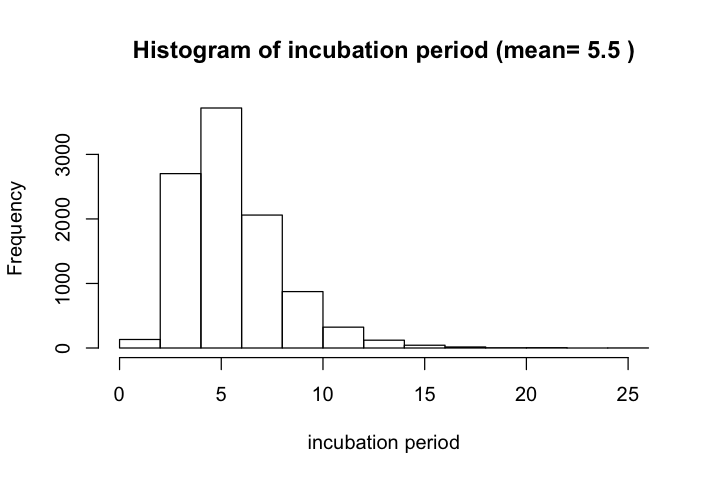

In [2]:
%get incubation_period
library(repr)

options(repr.plot.width=6, repr.plot.height=4)

hist(incubation_period, xlab='incubation period',
    main=paste('Histogram of incubation period (mean=',
              round(mean(incubation_period), 1), ')'))

### Serial interval

Serial interval is defined as the days between the primary case (infector) developing symptoms and seconday case (infectee) developing symptoms. According to [Nishiura et al](https://www.sciencedirect.com/science/article/pii/S1201971220301193?via%3Dihub), the mean serial interval for COVID-19 is 4.6 days with confidence interval between 3.5 and 5.9 days. These estimates agree with results from other sources such as [Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf).

Note that negative serial intervals are observed for COVID-19, meaning that the infectee developed symptoms before the infector, supporting the role of pre-symptomatic transmission.

**We use the distributions of serial intervals to validate our models** because serial intervals are combined results of incubation and virus transmission.

#### Technical details

[Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf) used a distribution of `N(3.96, 4.75)`, with `(3.53, 4.39)` as the 95% CI for mean, and `(4.46, 5.07)` as the 95% CI for standard deviation. This distribution is more realistic than the lognormal models used by other authors, who followed the traditional assumpion of positive serial intervals.

Data from Du et al has `12.6%` cases of negative serial intervals, which is less than the 20% percent of negative intervals as `N(3.86, 4.75)` indicates. We will use both quantities to validate our results. 

In [3]:
from scipy.stats import norm

# quantiles
serial_intervals = np.random.normal(loc=3.96, scale=4.75, size=10000)
np.quantile(serial_intervals, q=[0.025, 0.5, 0.975])

array([-5.59496794,  3.90203621, 13.11603939])

In [4]:
# percent of negative serial intervals
norm(3.96, 4.75).cdf(0)

0.2022294789782194

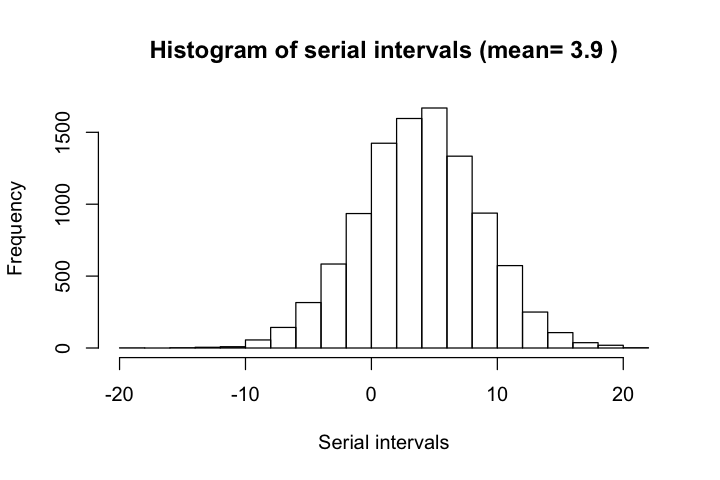

In [5]:
%get serial_intervals

hist(serial_intervals, xlab='Serial intervals',
    main=paste('Histogram of serial intervals (mean=',
              round(mean(serial_intervals), 1), ')'))

### Modeling Transmissibility 

There are very few study on the infectivity of COVID-19 at this point. [Wolfel et al](https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1.full.pdf) provided a detailed virological analysis of nine cases. They showed that the patients already have high RNA concentrations in throat swab, actually already on a declining stage when they were admitted with symptoms. The only good news was that live virus isolation were unsuccessful after day 8 in spite of ongoing high viral loads, so the patients were no longer infectious.

More and more studies have shown evidence of asymptomatic transmission so we tried several models of transmissibility with varying levels of asymptomatic transmission. We tried a constant model where infectors demonstrate constant transmissbility as well as a linear model where infectors demonstrate linearly increasing transmissibility. However, **none of the models yielded results that agreed with the observed serial transmissions.**.

Based on these experiments, we developed a model that assumes that **the transmissibility peaks at onset of symptoms, and declines before and after onset, following a normal distribution with 95% of infectivity happens in 14 days.** The distribution is truncated at left-hand side dpending on incubation period, and is scaled to have a total infectibity of R0, which is uniformly distributed from 1.4 to 2.8.

#### Technical details

For example, if the incubation period of a carrier is 4 days, and R0=2.2, the transmissibility is calculated as follows:

In [6]:
from scipy.stats import norm

In [7]:
def TransProb(incu, R0, interval=1/24):
    '''Transmission probability.    
    incu
        incubation period in days (can be float)
        
    R0
        reproductive number, which is the expected number of infectees
        
    interval
        interval of simulation, default to 1/24, which is by hours    
    
    returns
    
      x
          time point
      y
          probability of transmission for each time point
    '''
    x = np.linspace(0, incu + 14, (incu+14)/interval)
    dist = norm(incu, 3.572)
    y = dist.pdf(x)
    sum_y = sum(y)
    return x, y / sum(y) * R0

The following curve shows hourly probability of transmission from day 0 to 18, with a cummulative $R_0$ of 2.2.

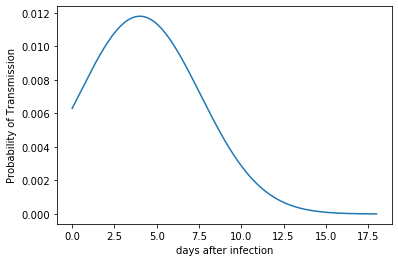

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

x,y = TransProb(4, 2.2)
plt.plot(x, y)
plt.xlabel('days after infection') 
plt.ylabel('Probability of Transmission')
plt.show()

#### Model validation

We simulated 10000 replicates of the transmissibility of an individual using the following scenario:
    
1. Incubationn periods drawn from a log normal distribution
2. $R_0$ dawn from a uniform distributed from 1.4 to 2.8

For every simulation,

1. The transmission probability is calculated as described above
2. A binomial distribution is applied at each hour to simulate the transmission of virus to another person. Overall number of infectees are recorded.
3. Incubation periods of infectees are drawn from the same log normal distribution
4. Serial intervals are calculated as the symptom date between the infector and infectee

In [9]:
def rand_incu(size=1):
    return np.random.lognormal(mean=1.621, sigma=0.418, size=size)

In [10]:
def Infect(incu, R0, interval=1/24):
    x, p = TransProb(incu, R0, interval)
    infected = np.random.binomial(1, p, len(x))
    n_infected = sum(infected)
    if n_infected > 0:
        incu = rand_incu()[0]
        first = list(infected).index(1)*interval
        symp = first + rand_incu()[0]
        si = symp - incu
        return n_infected, si
    else:
        return 0, 0


In [11]:
N = 10000

incubation_period = rand_incu(size=N)
R0 = np.random.uniform(1.4, 2.8, size=N)

all_r0 = []
all_r = []
all_si = []
for incu, r0 in zip(incubation_period, R0):
    all_r0.append(str(int(r0*10)/10))
    r, si = Infect(incu, r0)
    all_r.append(r)
    all_si.append(si)

In [12]:
%get all_r0 all_r all_si
all_r = as.numeric(all_r)
all_si = as.numeric(all_si)

The following table shows the mean number of infectees, and the mean, standard deviation, and. 5%, 50%, 95% quantiles of serial intervals.

As we can see, the mean number of infectees agree with specified $R_0$ quite well. The distributions of serial intervals are also consistent with the `N(3.96, 4.75)` distribution from  
[Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf), and the percent of negative serial intervals is actually smaller than what is expected the normal distribution (`20%`) and agrees better with the empirical data (`12.6%` to `16.35`).

In [13]:
library(plyr)
library(dplyr)
df=data.frame(R0=as.factor(all_r0), r=all_r, si=all_si)

ddply(df, .(R0), function(x) 
      { c(mean_r0=mean(x$r), 
        mean_si=mean(x$si),
        sd_si=sd(x$si),
        prop_neg=sum(x$si<0)/length(x$si),
        si=quantile(x$si, 0.05),
        si=quantile(x$si, 0.5),
        si=quantile(x$si, 0.95)
        ) })


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



R0,mean_r0,mean_si,sd_si,prop_neg,si.5%,si.50%,si.95%
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.4,1.550484,3.681103,4.566976,0.10235131,-2.052501,2.936002,11.42996
1.5,1.485396,3.992059,4.727824,0.09596662,-1.425836,2.948371,12.28890
1.6,1.701072,4.006204,4.734280,0.10321716,-1.720490,3.322901,12.89944
1.7,1.751857,3.468011,4.558472,0.15453195,-2.804432,2.700731,11.82849
1.8,1.845304,3.750905,4.675865,0.14364641,-2.456896,3.150872,12.08434
1.9,1.947977,3.887012,4.529086,0.11705202,-1.735531,3.317234,12.02763
2.0,2.008276,3.581156,4.693946,0.16000000,-2.665176,3.071954,11.68642
2.1,2.166434,3.982981,4.825433,0.14545455,-2.393610,3.320869,12.29004
2.2,2.332394,4.090370,4.553285,0.13802817,-2.554092,3.820015,11.87071


The overall distribution of serial intervals are `N(3.88, 4.70)`.

In [14]:
mean(df$si)
sd(df$si)

[1] 3.787684

[1] 4.61707

## Simulation of FPSO vessel with 64 individuals

Based on the transmisibility model we have developed, we simulate the aforementioned scenario at an hourly interval:

1. 64 individuals, with one newly introduced carrier
2. Whoever shows symptom are removed from the vessel
3. Simulation ends when there is no carrier on the vessel, or everyone is infected and eventually removed.

"Repeated infection" events, namely the infection of individuals who are already infected with the virus, are ignored. Although repeated infections could in theory accerlerate the onset of symptom of infectees, they are rare events and should not affect the results of the simulations.

The simulation program also allows for the following options:

1. Keeping of symptomatic individuals, as a way to show what would happen if we allow the virus to spread.
2. Pre-quarantine the crew before he or she is onboard. This allows us to estimate the risk if we send only people who have been in quarantine to FPSO.

### Scenarios with removal of symptomatic crews

After running 10000 repeated simulations, we observe an average duration of outbreak of 15.3 days, with a median of 9.2 days. The outbreak could last as long as two months.

In [15]:
data = read.table('simu_remove_symptomatic.log', sep='\t', header=1)
end_count = data[data['event'] == 'END',]

In [16]:
quantile(end_count$time, c(0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975))

2.5%       5%      25%      50%      75%      95%    97.5% 
 2.51000  2.95000  5.27000  9.22000 19.12250 47.94050 60.37075

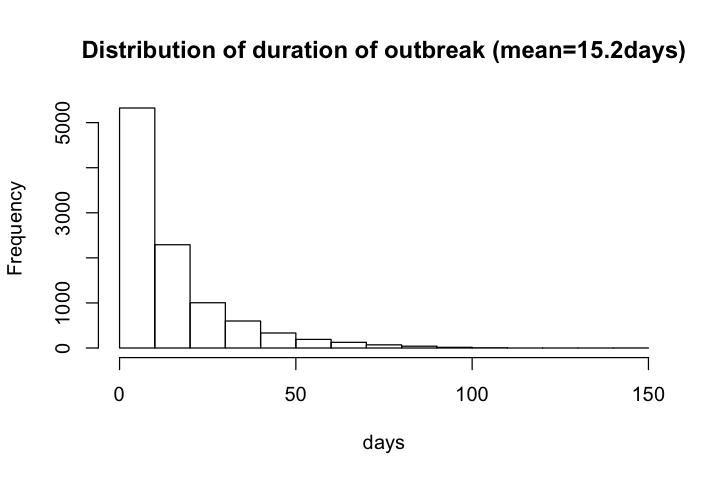

In [17]:
hist(end_count$time, 
     main=paste0('Distribution of duration of outbreak (mean=',
                 round(mean(end_count$time), 1), 'days)'),
     xlab='days')

After the outbreak of COVID-19, on average 7 infectees will show symptoms and be removed. In about a quarter of the cases the initial infectee will shown symptom and be removed without infecting others. However, in 5% of cases more than half (35) of the crews will be infected and removed.

In [18]:
quantile(end_count$individual, c(0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975))

2.5%    5%   25%   50%   75%   95% 97.5% 
   20    31    58    62    63    63    63

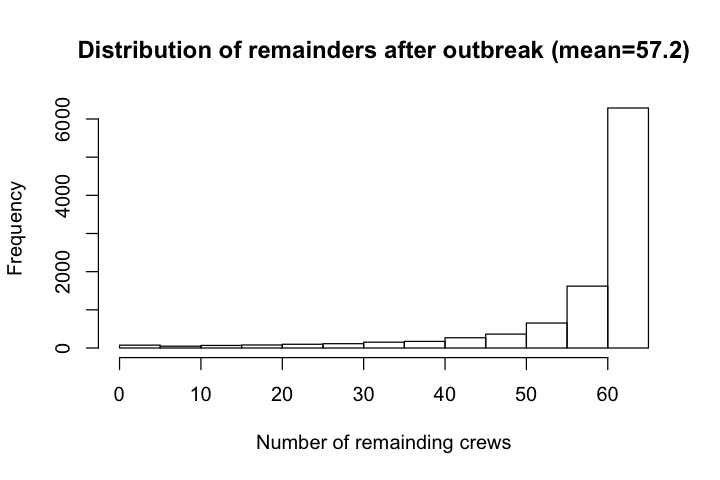

In [19]:
hist(end_count$individual, xlab='Number of remainding crews', 
      main=paste0('Distribution of remainders after outbreak (mean=',
                  round(mean(end_count$individual), 1), ')'))

The mean time for the infector to show symptom is 5.5 days, with 95% times falling between 2.23 and 11.43 days. The time would be slightly shorter at 5.4 days for "anyone" to show symptom because in ~12% cases the infectees show symptoms earlier. 

In [20]:
removals = data[data$event == 'REMOVE',]
infector_removals = removals[removals$individual == 0,]

In [21]:
quantile(infector_removals$time, c(0.025, 0.5, 0.975))

2.5%     50%   97.5% 
 2.2300  5.0400 11.4305

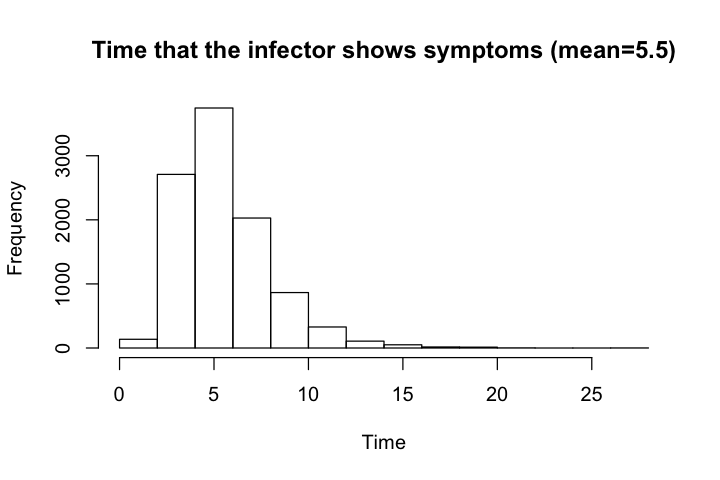

In [22]:
hist(infector_removals$time, 
    xlab='Time', main=paste0('Time that the infector shows symptoms (mean=',
        round(mean(infector_removals$time), 1), ')'
    ))

In [23]:
# look for first removal
start = FALSE
first_removal = c()
for (row in 1:nrow(data)) {
    if (data[row, "event"] == 'INFECTION' && data[row, "time"] == 0.0) {
        start = TRUE;
        next
    }
    if (start && data[row, "event"] == 'REMOVE') {
        first_removal = append(first_removal, data[row, "time"]);
        start = FALSE;
    }
}

In [24]:
mean(first_removal)

[1] 5.414694

### Simulations for keeping symptomatic individuals

If symptomatic individuals are kept around and no social distancing happens after that. It is not surprising that all crews will be infected, however we have hoped that a (very small) fraction of scenarios the virus does not transmit before the first affected individual becomes non-infectious.

In [25]:
data = read.table('simu_keep_symptomatic.log', sep='\t', header=1)
data = data[data['event'] == 'END',]

The average duration of outbreak is 15.3 days, with a median of 9.2 days.

In [26]:
quantile(data$individual, c(0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975))

2.5%    5%   25%   50%   75%   95% 97.5% 
   64    64    64    64    64    64    64

The simulations show a bi-modal curve for how long the outbreaks last, which seems to suggest that the outbreak will either wipe out everyone in the first around, or spread silently for a while and infect everyone during a later outbreak.

In [27]:
quantile(data$time, c(0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975))

2.5%      5%     25%     50%     75%     95%   97.5% 
 0.0000  0.0000 43.0975 54.9250 66.1800 86.6620 94.1005

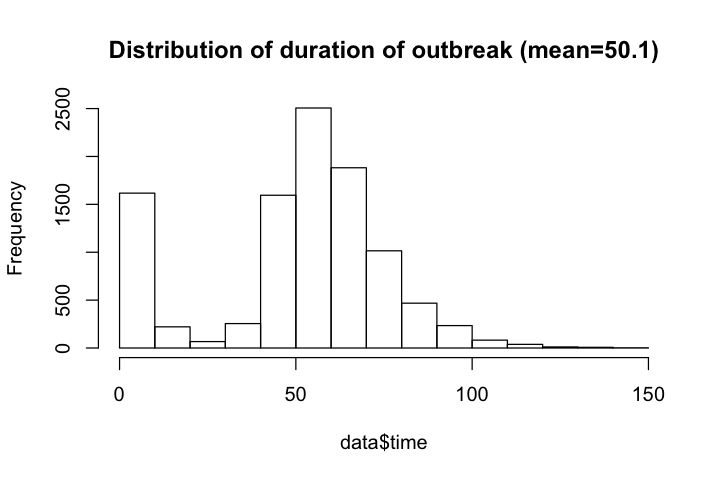

In [28]:
hist(data$time, main=paste0('Distribution of duration of outbreak (mean=', round(mean(data$time), 1), ')'))

### Simulations for pre-quarantine

If we quarantine the individual who is supposed to be sent to the vessle for a period of time, it is likely that he or she will show symptom before the mission, or he or she will show symptom much faster on vessel which gives less chance for the virus to spread.

If we set the pre-quarantine time to 7 days, out of 10000 simulations, in 77.4% of cases the mission will be aborted because the infector shows symptoms before entering the vessel, in another 16.0% cases the infector will show symptom quickly and be removed before he or she infect others. In the rest of 6.5% cases, the virus will spread.

In [29]:
data = read.table('simu_pre_quarantine.log', sep='\t', header=1)
data = data[data['event'] == 'END',]

In [30]:
# table of individuals left at the end of simulation
table(data$individual)


   0    1    2    6    7   10   12   13   15   16   17   18   19   20   21   22 
   3    1    3    2    1    2    1    1    2    1    1    1    1    4    2    1 
  23   24   25   26   27   28   29   30   31   32   33   35   36   37   38   39 
   1    2    2    2    1    3    2    1    3    3    5    3    4    5    2    5 
  40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55 
   5    5    3    4    4   11    1    6    8    5   10   11    8    9    8   13 
  56   57   58   59   60   61   62   63   64 
  17   24   25   27   55   87  237 1602 7744 

If we extend the pre-quarantine days to 14, the infector will enter the vessle in only `0.83%` of the cases, and will infect someone else in `0.26%` of the cases.

In [31]:
data = read.table('simu_pre_quarantine_14.log', sep='\t', header=1)
data = data[data['event'] == 'END',]
table(data$individual)


   8   28   38   49   53   56   57   59   60   61   62   63   64 
   1    1    1    1    1    2    2    3    3    4    7   57 9917 